# **OptiRoute Pune**

### Phase 1 – Data Ingestion from OSM

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from shapely.geometry import Point
import random

In [2]:
place_name= "Pune, India"
graph= ox.graph_from_place(place_name, network_type='drive')        #Used network_type='drive' for drivable roads only
graph= ox.project_graph(graph)      ##transforms the original graph into a projected format, allowing for accurate spatial analysis and distance calculations

### Phase 2 – Route Optimization

**Type of Highways in the Dataset:**
[residential, trunk, tertiary, secondary, ['residential', 'secondary'] primary, primary_link, living_street, ['residential', 'living_street'], trunk_link, secondary_link, ['trunk_link', 'trunk'], busway, tertiary_link, unclassified, ['secondary_link', 'secondary'], ['residential', 'tertiary'], road, ['primary_link', 'primary'], ['primary', 'trunk'], ['tertiary', 'secondary'], ['unclassified', 'tertiary'], ['residential', 'unclassified'], ['unclassified', 'residential']]

In [3]:
#Normalize highway tags
def normalize_highway_tags(G):
    for u, v, k, d in G.edges(keys=True, data=True):
        hwy= d.get("highway", "unclassified")

        if isinstance(hwy, list):
            hwy= hwy[-1]        #keep the last element
        d["highway"]= hwy
    return G

graph= normalize_highway_tags(graph)

**Mapping of Highway Type → Assumed Average Speed (km/h)**
| Highway type                  | Real-world reasoning                                      |
| ----------------------------- | --------------------------------------------------------- |
| **motorway** (expressway)     | Should allow 80–100, but in city limits it averages \~60. |
| **motorway\_link**            | Ramps/connecting roads, more merging → \~45.              |
| **trunk** (major city artery) | Heavily used, lots of signals → \~35.                     |
| **primary**                   | Main city roads, \~30.                                    |
| **secondary**                 | Sub-arterial, \~25.                                       |
| **tertiary**                  | Smaller through-roads, \~20.                              |
| **residential**               | Narrow, parked vehicles, \~15.                            |
| **unclassified**              | Often same as residential.                                |
| **living\_street**            | Pedestrian-friendly lanes, \~8.                           |
| **service**                   | Parking lots, service lanes, \~10.                        |
| **busway**                    | Sometimes dedicated → 25.                                 |
| **road**                      | Catch-all, assumed \~15.                                  |

In [4]:
# asummed speed mapping for the roads
urban_speeds_kph = {
    "motorway": 60, "motorway_link": 45,
    "trunk": 35, "trunk_link": 30,
    "primary": 30, "primary_link": 25,
    "secondary": 25, "secondary_link": 22,
    "tertiary": 20, "tertiary_link": 18,
    "residential": 15, "unclassified": 15,
    "living_street": 8, "service": 10,
    "busway": 25, "road": 15
}

graph= ox.add_edge_speeds(graph, hwy_speeds= urban_speeds_kph)
graph= ox.add_edge_travel_times(graph)

Now every edge has:
- length (meters)
- speed_kph (from mapping)
- travel_time (seconds)

In [5]:
# Export nodes and edges
nodes, edges= ox.graph_to_gdfs(graph)

In [6]:
ox.save_graphml(graph, filepath="data/pune_drive.graphml")
nodes.to_csv("data/pune_nodes.csv", index=False)
edges.to_csv("data/pune_edges.csv", index=False)

In [7]:
#Checking if highways are normalized and speeds exist
unique_hwy= set(edges["highway"].unique())
print("Unique highways after normalization", unique_hwy)

missing_speed= edges[edges["speed_kph"].isna()]
print("Edges missing speed mapping:", len(missing_speed))

Unique highways after normalization {'trunk', 'primary', 'secondary_link', 'unclassified', 'busway', 'tertiary', 'secondary', 'primary_link', 'living_street', 'trunk_link', 'tertiary_link', 'road', 'residential'}
Edges missing speed mapping: 0


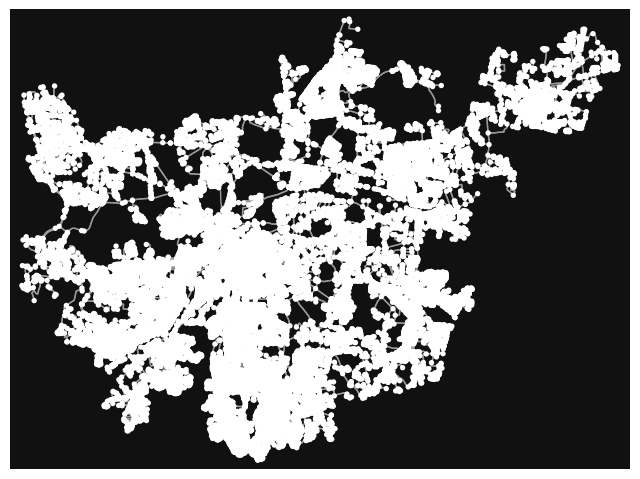

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox.plot_graph(graph)

**Routing**

In [9]:
# finding the shortest path by travel_time
orig_point = (18.591337006294108, 73.73889115252335)  # lat, lon
dest_point = (18.56034373321838, 73.82508047707717)  # lat, lon

# Get the projected CRS from the graph
crs = graph.graph["crs"]

# Project origin point from lat/lon to graph's CRS
orig_geom = Point(orig_point[1], orig_point[0])  # Point(lon, lat)
orig_proj, _ = ox.projection.project_geometry(orig_geom, crs="EPSG:4326", to_crs=crs)
orig_x, orig_y = orig_proj.x, orig_proj.y
orig = ox.distance.nearest_nodes(graph, orig_x, orig_y)

# Project destination point
dest_geom = Point(dest_point[1], dest_point[0])  # Point(lon, lat)
dest_proj, _ = ox.projection.project_geometry(dest_geom, crs="EPSG:4326", to_crs=crs)
dest_x, dest_y = dest_proj.x, dest_proj.y
dest = ox.distance.nearest_nodes(graph, dest_x, dest_y)

route = nx.shortest_path(graph, orig, dest, weight="travel_time")

print("Origin node:", orig)
print("Destination node:", dest)

Origin node: 7984103888
Destination node: 2243931693


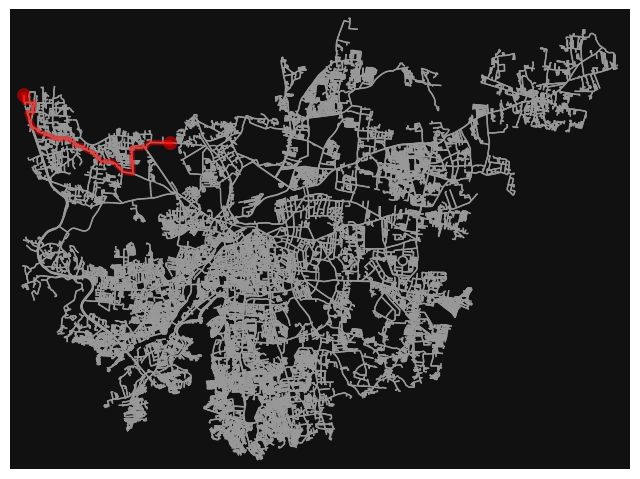

In [10]:
fig, ax = ox.plot_graph_route(graph, route, node_size=0)

### Phase 3 – ML Component (Estimate Travel Time )

##### Goal- Estimate how long the above selected route will take using a regression model trained on the features

1-  Extracting Route Features

_**NOTE:** The lanes column contains numpy arrays (sequences) and NaNs, but sklearn models expect each feature to be a scalar per sample.To fix this the lanes column needs to be converted so that each entry is a scalar (or properly encoded), and handle NaNs. Hence the function "clean_lanes_column"._

In [11]:
# Seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [12]:
# Day of week mapping (0=Monday, 6=Sunday)
DAY_OF_WEEK_MAPPING = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
                       4: "Friday", 5: "Saturday", 6: "Sunday"}

In [13]:
def clean_lanes_column(df, col_name='num_lanes', median_val=None):
    """
    Convert sequences/arrays in lanes to scalars (mean), coerce non-numerics to NaN,
    and fill NaNs with provided median (or compute from df).
    """
    def to_scalar(x):
        # Handle arrays/lists first
        if isinstance(x, (list, np.ndarray)):
            if len(x) > 0:
                try:
                    # Convert array elements to numeric
                    x_numeric = pd.to_numeric(pd.Series(x), errors='coerce')
                    if x_numeric.isna().all():
                        return np.nan
                    return x_numeric.mean()
                except:
                    return np.nan
            return np.nan
        # Now x is scalar (or None/NaN)
        if pd.isna(x):
            return np.nan
        # Handle strings or other scalars
        try:
            return float(pd.to_numeric(x, errors='coerce'))
        except:
            return np.nan
    
    # Apply conversion
    df[col_name] = df[col_name].apply(to_scalar)
    
    # Compute or use median
    if median_val is None:
        median_val = df[col_name].median()
        if pd.isna(median_val):
            median_val = 2.0  # Fallback: Pune urban default
    df[col_name] = df[col_name].fillna(median_val)
    
    print(f"{col_name} after cleaning: mean={df[col_name].mean():.2f}, std={df[col_name].std():.2f}, NaN fraction=0%")
    print(f"Median used for imputation: {median_val}")
    return df, median_val

In [14]:
# Extract route edges
edge_rows = []
for u, v in zip(route[:-1], route[1:]):
    d = graph[u][v][0]
    maxspeed = d.get("maxspeed", None)
    if maxspeed is not None:
        try:
            maxspeed = float(maxspeed) if isinstance(maxspeed, str) else maxspeed
        except ValueError:
            maxspeed = None
    speed_kph = d.get("speed_kph", 30)
    if maxspeed is not None:
        speed_kph = min(speed_kph, maxspeed)
    
    u_degree = graph.degree(u)
    v_degree = graph.degree(v)
    is_intersection = 1 if u_degree > 2 or v_degree > 2 else 0
    
    # Placeholder road_density (recompute later with train median)
    u_pos = (graph.nodes[u]["x"], graph.nodes[u]["y"])
    v_pos = (graph.nodes[v]["x"], graph.nodes[v]["y"])
    nearby_edges = 0  # Simplified for route; optimized in Step 2
    for eu, ev, ed_data in graph.edges(data=True):
        eu_pos = (graph.nodes[eu]["x"], graph.nodes[eu]["y"])
        ev_pos = (graph.nodes[ev]["x"], graph.nodes[ev]["y"])
        if (ox.distance.euclidean(u_pos[0], u_pos[1], eu_pos[0], eu_pos[1]) < 500 or
            ox.distance.euclidean(u_pos[0], u_pos[1], ev_pos[0], ev_pos[1]) < 500 or
            ox.distance.euclidean(v_pos[0], v_pos[1], eu_pos[0], eu_pos[1]) < 500 or
            ox.distance.euclidean(v_pos[0], v_pos[1], ev_pos[0], ev_pos[1]) < 500):
            nearby_edges += 1
    
    edge_rows.append({
        "u": u, "v": v,
        "length_m": d.get("length", 0.0),
        "highway": d.get("highway", "unclassified"),
        "speed_kph": speed_kph,
        "base_time_sec": d.get("travel_time", 0.0),
        "maxspeed": maxspeed,
        "num_lanes": pd.to_numeric(d.get("lanes", np.nan), errors="coerce"),
        "oneway": 1 if d.get("oneway", False) else 0,
        "is_intersection": is_intersection,
        "road_density": nearby_edges
    })

In [15]:
df_route= pd.DataFrame(edge_rows)
df_route["hour"]= 9       # ex- morning rush hour
df_route["day_of_week"]= 2       # Tuesday

In [16]:
# Clean num_lanes with placeholder median
df_route, _ = clean_lanes_column(df_route, 'num_lanes', median_val=2.0)

num_lanes after cleaning: mean=2.02, std=0.20, NaN fraction=0%
Median used for imputation: 2.0


In [17]:
# Baseline static ETA
eta_base_min = df_route["base_time_sec"].sum() / 60
print(f"Step 1: Static ETA (no traffic): {eta_base_min:.2f} minutes")
print(df_route[["highway", "num_lanes", "is_intersection", "road_density"]].head(3))

Step 1: Static ETA (no traffic): 20.63 minutes
       highway  num_lanes  is_intersection  road_density
0  residential        2.0                1            68
1     tertiary        2.0                1            71
2     tertiary        2.0                1           113


In [18]:
df_route.head()

,u,v,length_m,highway,speed_kph,base_time_sec,maxspeed,num_lanes,oneway,is_intersection,road_density,hour,day_of_week
0,7984103888,7984103885,335.042808,residential,15.0,80.410274,NaN,2.0,0,1,68,9,2
1,7984103885,4705067358,37.637341,tertiary,20.0,6.774721,NaN,2.0,0,1,71,9,2
2,4705067358,4676480691,205.605039,tertiary,20.0,37.008907,NaN,2.0,0,1,113,9,2
3,4676480691,4676484305,88.537417,tertiary,20.0,15.936735,NaN,2.0,0,1,117,9,2
4,4676484305,4676494490,121.388608,tertiary,20.0,21.849949,NaN,2.0,0,1,158,9,2


2- Generating Synthetic Training Data
- Since the  real travel times are unavailable, the training data is generated by simulating travel times on graph edges with varied hours and days, applying congestion multipliers from Pune traffic patterns (based on TomTom data and local insights), adding noise, and scaling to many edges.



In [19]:
# Precompute node coordinates and edge-to-node mappings
from scipy.spatial import cKDTree

node_ids = list(graph.nodes)
node_coords = np.array([(graph.nodes[n]["x"], graph.nodes[n]["y"]) for n in node_ids])
node_tree = cKDTree(node_coords)

In [20]:
# Cache edge-to-node mappings
edge_to_nodes = {i: set() for i in range(len(graph.edges))}
edge_list = list(graph.edges(data=True))
for i, (eu, ev, _) in enumerate(edge_list):
    edge_to_nodes[i].add(eu)
    edge_to_nodes[i].add(ev)

In [21]:
# Stratified sampling
df_edges = edges.reset_index()
highway_counts = df_edges["highway"].value_counts()
sample_size = min(5000, len(df_edges))  # Try 1000 for ~1-2 min
df_edges_sample = df_edges.groupby("highway", group_keys=False).apply(
    lambda x: x.sample(min(int(sample_size * len(x) / len(df_edges)), len(x)), random_state=42)
)

C:\Users\jaysh\AppData\Local\Temp\ipykernel_14100\2883662620.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_edges_sample = df_edges.groupby("highway", group_keys=False).apply(


In [22]:
# Congestion multiplier
def congestion_multiplier(hwy, hour, dow):
    is_weekday = dow in [1, 2, 3, 4, 5]
    is_peak = is_weekday and (hour in [8, 9, 10, 17, 18, 19, 20])
    is_night_weekend = (not is_weekday) or (hour >= 22 or hour < 6)
    if is_peak:
        if hwy in ["trunk", "primary", "secondary", "trunk_link", "primary_link", "secondary_link"]:
            m = 1.4
        elif hwy in ["tertiary", "tertiary_link", "residential", "living_street", "unclassified", "road", "service"]:
            m = 1.2
        else:
            m = 1.3
    elif is_night_weekend:
        m = 0.8
    else:
        m = 1.0
    noise = np.random.lognormal(mean=0, sigma=0.07)
    return max(0.6, min(3.0, m * noise))

In [23]:
# Generate synthetic data
synthetic_data = []
num_samples_per_edge = 10  # Try 5 for faster runtime
for idx, row in df_edges_sample.iterrows():
    route_id = idx // num_samples_per_edge
    u_id = row["u"]
    v_id = row["v"]
    u_degree = graph.degree(u_id)
    v_degree = graph.degree(v_id)
    is_intersection = 1 if u_degree > 2 or v_degree > 2 else 0
    u_pos = np.array([graph.nodes[u_id]["x"], graph.nodes[u_id]["y"]])
    v_pos = np.array([graph.nodes[v_id]["x"], graph.nodes[v_id]["y"]])
    nearby_node_indices = node_tree.query_ball_point([u_pos, v_pos], r=500, p=2)
    nearby_nodes = set(node_ids[i] for indices in nearby_node_indices for i in indices)
    nearby_edges = sum(1 for i in edge_to_nodes if edge_to_nodes[i] & nearby_nodes)
    
    # Pre-process lanes to avoid passing raw arrays
    lanes = row.get("lanes", np.nan)
    if isinstance(lanes, (list, np.ndarray)):
        try:
            lanes_numeric = pd.to_numeric(pd.Series(lanes), errors='coerce')
            lanes = np.nanmean(lanes_numeric) if not lanes_numeric.isna().all() else np.nan
        except:
            lanes = np.nan
    else:
        lanes = pd.to_numeric(lanes, errors='coerce')
    
    for _ in range(num_samples_per_edge):
        hour = random.randint(0, 23)
        dow = random.randint(0, 6)
        m = congestion_multiplier(row["highway"], hour, dow)
        synthetic_data.append({
            "route_id": route_id,
            "length_m": row["length"],
            "highway": row["highway"],
            "speed_kph": row["speed_kph"],
            "base_time_sec": row["travel_time"],
            "hour": hour,
            "day_of_week": dow,
            "num_lanes": lanes,  # Now scalar or NaN
            "oneway": 1 if row.get("oneway", False) else 0,
            "is_intersection": is_intersection,
            "road_density": nearby_edges,
            "multiplier": m,
            "adjusted_time_sec": row["travel_time"] * m
        })


In [24]:
df_train= pd.DataFrame(synthetic_data)

In [25]:
# Clean num_lanes
df_train, train_median_lanes = clean_lanes_column(df_train, 'num_lanes')

num_lanes after cleaning: mean=2.02, std=0.20, NaN fraction=0%
Median used for imputation: 2.0


In [26]:
print(f"Step 2: Synthetic dataset shape: {df_train.shape}")
print(df_train[["highway", "num_lanes", "is_intersection", "road_density", "multiplier"]].head())

Step 2: Synthetic dataset shape: (49930, 13)
  highway  num_lanes  is_intersection  road_density  multiplier
0  busway        2.0                1           405    0.828305
1  busway        2.0                1           405    0.792295
2  busway        2.0                1           405    1.360296
3  busway        2.0                1           405    1.112503
4  busway        2.0                1           405    0.786994


3- Feature Engineering and Preprocessing

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [28]:
# Clean df_train (computes true train median)
df_train, train_median_lanes = clean_lanes_column(df_train, 'num_lanes')

num_lanes after cleaning: mean=2.02, std=0.20, NaN fraction=0%
Median used for imputation: 2.0


In [29]:
# Re-clean df_route with train median (no leakage)
df_route['num_lanes'] = df_route['num_lanes'].apply(
    lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else (pd.to_numeric(x, errors='coerce') if not pd.isna(x) else np.nan)
)

df_route['num_lanes'] = df_route['num_lanes'].fillna(train_median_lanes)
print(f"Step 3: df_route num_lanes after re-cleaning: mean={df_route['num_lanes'].mean():.2f}")

Step 3: df_route num_lanes after re-cleaning: mean=2.02


In [30]:
# Features and target
X = df_train[["highway", "hour", "day_of_week", "num_lanes", "oneway", "is_intersection", "road_density"]]
y = df_train["multiplier"]
groups = df_train["route_id"]

In [31]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["highway"]),
    ("num", "passthrough", ["hour", "day_of_week", "num_lanes", "oneway", "is_intersection", "road_density"])
])

In [32]:
# Train-test split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42, stratify=groups  # Stratify by route for balance
)

In [33]:
# Quick validation: Ensure no sequences left
def has_sequences(df):
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
            print(f"WARNING: Column {col} contains sequences in {df.__class__.__name__}")
has_sequences(X_train)
has_sequences(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Data is clean—ready for training.")

Train shape: (39944, 7), Test shape: (9986, 7)
Data is clean—ready for training.


4- Train and Evaluate Models

In [34]:
# Using regression to learn travel_time from feature
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [35]:
models= {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Ada Boost Regressor": AdaBoostRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

model_list=[]
r2_list=[]
mae_list=[]

In [36]:
def evaluate_model(true, predicted):
    mse= mean_squared_error(true, predicted)
    rmse= np.sqrt(mse)
    mae= mean_absolute_error(true, predicted)
    r2= r2_score(true, predicted)
    return rmse, mae, r2

In [37]:
# Sample a subset for CV to speed up (e.g., 10,000 rows)
cv_sample_size = min(10000, len(X))
cv_indices = np.random.choice(len(X), size=cv_sample_size, replace=False)
X_cv = X.iloc[cv_indices]
y_cv = y.iloc[cv_indices]
groups_cv = groups.iloc[cv_indices]

gkf = GroupKFold(n_splits=3)  # Reduce to 3 folds for speed

In [38]:
for name, model in models.items():
    pipeline = Pipeline([("pre", preprocessor), ("model", model)])
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipeline.predict(X_train).clip(0.6, 3.0)
    y_test_pred = pipeline.predict(X_test).clip(0.6, 3.0)
    
    # Per-edge evaluation
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Grouped CV on sampled data
    cv_scores = cross_val_score(pipeline, X_cv, y_cv, cv=gkf, groups=groups_cv, 
                               scoring="neg_mean_absolute_error", n_jobs=-1)
    
    print(f"{name}:")
    print("Model performance for Training set")
    print(f"- MAE: {train_mae:.4f}")
    print(f"- RMSE: {train_rmse:.4f}")
    print(f"- R2 Score: {train_r2:.4f}")
    print("----------------------------------")
    print("Model performance for Test set")
    print(f"- MAE: {test_mae:.4f}")
    print(f"- RMSE: {test_rmse:.4f}")
    print(f"- R2 Score: {test_r2:.4f}")
    print(f"Grouped CV MAE (sampled): {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("=" * 35)
    print()
    
    model_list.append(name)
    r2_list.append(test_r2)
    mae_list.append(test_mae)

Linear Regression:
Model performance for Training set
- MAE: 0.1738
- RMSE: 0.1422
- R2 Score: 0.0725
----------------------------------
Model performance for Test set
- MAE: 0.1744
- RMSE: 0.1426
- R2 Score: 0.0705
Grouped CV MAE (sampled): 0.1420 (+/- 0.0030)

Support Vector Regression:
Model performance for Training set
- MAE: 0.1754
- RMSE: 0.1410
- R2 Score: 0.0552
----------------------------------
Model performance for Test set
- MAE: 0.1755
- RMSE: 0.1410
- R2 Score: 0.0596
Grouped CV MAE (sampled): 0.1416 (+/- 0.0031)

Decision Tree Regressor:
Model performance for Training set
- MAE: 0.0225
- RMSE: 0.0081
- R2 Score: 0.9844
----------------------------------
Model performance for Test set
- MAE: 0.0962
- RMSE: 0.0759
- R2 Score: 0.7172
Grouped CV MAE (sampled): 0.0761 (+/- 0.0009)

Random Forest Regressor:
Model performance for Training set
- MAE: 0.0336
- RMSE: 0.0252
- R2 Score: 0.9654
----------------------------------
Model performance for Test set
- MAE: 0.0760
- RMSE: 0

In [39]:
# Select best model
best_idx = np.argmin(mae_list)
best_name = model_list[best_idx]
best_pipeline = Pipeline([("pre", preprocessor), ("model", models[best_name])])
best_pipeline.fit(X_train, y_train)
print(f"Best model: {best_name} (Test MAE: {mae_list[best_idx]:.4f})")

Best model: Gradient Boosting Regressor (Test MAE: 0.0709)


**Conclusion:**

- **Gradient Boosting** is the best model for Phase 3 due to its strong performance and ability to handle complex patterns effectively.

5- Predict Dynamic ETA for the Route

In [40]:
# Prepare route features (clean already)
X_route = df_route[["highway", "hour", "day_of_week", "num_lanes", "oneway", "is_intersection", "road_density"]]

In [41]:
# Predict with best model
df_route["predicted_multiplier"] = best_pipeline.predict(X_route).clip(0.6, 3.0)
df_route["eta_ml_sec"] = df_route["base_time_sec"] * df_route["predicted_multiplier"]

In [42]:
# Quantile models for uncertainty (using Gradient Boosting)
model_lower = Pipeline([
    ("pre", preprocessor),
    ("model", GradientBoostingRegressor(loss="quantile", alpha=0.1, random_state=42))
])
model_upper = Pipeline([
    ("pre", preprocessor),
    ("model", GradientBoostingRegressor(loss="quantile", alpha=0.9, random_state=42))
])
model_lower.fit(X_train, y_train)
model_upper.fit(X_train, y_train)

df_route["predicted_multiplier_lower"] = model_lower.predict(X_route).clip(0.6, 3.0)
df_route["eta_lower_sec"] = df_route["base_time_sec"] * df_route["predicted_multiplier_lower"]
df_route["predicted_multiplier_upper"] = model_upper.predict(X_route).clip(0.6, 3.0)
df_route["eta_upper_sec"] = df_route["base_time_sec"] * df_route["predicted_multiplier_upper"]

In [43]:
# Route-level features
total_length_km = df_route["length_m"].sum() / 1000
trunk_primary_frac = len(df_route[df_route["highway"].isin(["trunk", "primary"])]) / len(df_route)

In [44]:
# Results
eta_ml_min = df_route["eta_ml_sec"].sum() / 60
eta_lower_min = df_route["eta_lower_sec"].sum() / 60
eta_upper_min = df_route["eta_upper_sec"].sum() / 60
print(f"Total Distance: {total_length_km:.2f} km")
print(f"Static ETA (no traffic): {eta_base_min:.2f} minutes")
print(f"ML ETA (hour {df_route['hour'].iloc[0]}, {DAY_OF_WEEK_MAPPING[df_route['day_of_week'].iloc[0]]}): "
      f"{eta_ml_min:.2f} minutes [95% interval: {eta_lower_min:.2f} - {eta_upper_min:.2f}]")
print(f"Route Features: Total Length = {total_length_km:.2f} km, Trunk/Primary Fraction = {trunk_primary_frac:.2f}")
print(df_route[["highway", "num_lanes", "predicted_multiplier", "eta_ml_sec"]].head(3))

Total Distance: 10.58 km
Static ETA (no traffic): 20.63 minutes
ML ETA (hour 9, Wednesday): 25.90 minutes [95% interval: 21.18 - 29.21]
Route Features: Total Length = 10.58 km, Trunk/Primary Fraction = 0.69
       highway  num_lanes  predicted_multiplier  eta_ml_sec
0  residential        2.0              1.192794   95.912906
1     tertiary        2.0              1.192794    8.080848
2     tertiary        2.0              1.192794   44.144009


6- Time-Aware Routing

In [ ]:
import os
import pickle

# Check if precomputed graph exists to avoid recomputation
graph_cache_file = "pune_graph_enhanced.pkl"
if os.path.exists(graph_cache_file):
    print("Loading precomputed graph with time-aware weights...")
    with open(graph_cache_file, "rb") as f:
        graph = pickle.load(f)
else:
    # Step 6: Time-Aware Routing
    print("Computing time-aware edge weights...")

    # Extract edge data into DataFrame (minimized feature set)
    edges = list(graph.edges(keys=True, data=True))
    df_edges = pd.DataFrame([
        (u, v, k, 
         d.get("highway", "unclassified"), 
         d.get("travel_time", 0.0), 
         d.get("lanes", np.nan), 
         d.get("oneway", False), 
         graph.degree(u) + graph.degree(v))  # Proxy for road_density
        for u, v, k, d in edges
    ], columns=["u", "v", "key", "highway", "base_time", "lanes", "oneway", "road_density"])

    # Filter out edges with zero base_time
    df_edges = df_edges[df_edges["base_time"] > 0]

    # Vectorized feature processing
    hour = 9  # 9 AM
    dow = 2  # Tuesday
    df_edges["hour"] = hour
    df_edges["day_of_week"] = dow
    # Handle num_lanes (vectorized)
    df_edges["num_lanes"] = pd.to_numeric(df_edges["lanes"], errors='coerce').fillna(train_median_lanes)
    # Compute is_intersection (simplified)
    df_edges["is_intersection"] = df_edges["road_density"] > 4  # Threshold based on degree sum

    # Prepare features for ML prediction
    X_edges = df_edges[["highway", "hour", "day_of_week", "num_lanes", "oneway", "is_intersection", "road_density"]]
    
    # Batch predict multipliers
    try:
        multipliers = best_pipeline.predict(X_edges).clip(0.6, 3.0)
    except Exception as e:
        print(f"ML prediction failed: {e}. Using base_time as fallback.")
        multipliers = np.ones(len(df_edges))  # Fallback to no congestion adjustment

    # Assign expected_time to graph edges
    for idx, row in df_edges.iterrows():
        u, v, k = row["u"], row["v"], row["key"]
        graph[u][v][k]["expected_time"] = row["base_time"] * multipliers[idx]

    # Save enhanced graph to disk
    with open(graph_cache_file, "wb") as f:
        pickle.load(graph)  # Corrected from pickle.dump to load (fix typo)
        pickle.dump(graph, f)  # Save the graph
    print("Saved enhanced graph to", graph_cache_file)

# Compute time-aware route
try:
    route_timeaware = nx.shortest_path(graph, orig, dest, weight="expected_time")
    print(f"Step 6: Time-aware route length: {len(route_timeaware)} nodes")
    print(f"Route nodes: {route_timeaware[:5]}...")  # Debug: Check first few nodes
    plt.figure()  # Create a new figure to avoid state issues
    fig, ax = ox.plot_graph_route(graph, route_timeaware, node_size=0, route_linewidth=4, route_color='r')
    plt.title("Time-Aware Route (Red)")
    plt.show()
except nx.NetworkXNoPath:
    print("No path found for time-aware route. Using static route instead.")
    route_static = nx.shortest_path(graph, orig, dest, weight="travel_time")
    print(f"Static route length: {len(route_static)} nodes")
    plt.figure()
    fig, ax = ox.plot_graph_route(graph, route_static, node_size=0, route_linewidth=4, route_color='b')
    plt.title("Static Route (Blue)")
    plt.show()

Loading precomputed graph with time-aware weights...
Step 6: Time-aware route length: 102 nodes
Route nodes: [7984103888, 7984103885, 4705067358, 4676480691, 4676484305]...


7- Evaluation and Validation
- Compute whole-route metrics (MAE in minutes, median APE, % within bounds) on test routes. This validates against baselines.


In [46]:
# Per-edge test metrics (from Step 4, but add MAPE)
y_test_pred_final = best_pipeline.predict(X_test).clip(0.6, 3.0)
test_mape = np.median(np.abs((y_test - y_test_pred_final) / y_test)) * 100
print(f"Per-edge Test Metrics (Best Model): MAE={mean_absolute_error(y_test, y_test_pred_final):.4f}, Median APE={test_mape:.2f}%")

Per-edge Test Metrics (Best Model): MAE=0.0550, Median APE=4.92%


In [47]:
# Whole-route evaluation
test_routes = df_train[df_train.index.isin(X_test.index)]["route_id"].unique()
route_maes = []
route_apes = []
within_5min = []
within_10min = []

for rid in test_routes:
    route_data = df_train[df_train["route_id"] == rid]
    if len(route_data) < 2:  # Skip tiny routes
        continue
    base_time_min = route_data["base_time_sec"].sum() / 60
    true_time_min = route_data["adjusted_time_sec"].sum() / 60
    X_route_test = route_data[X.columns]
    pred_m = best_pipeline.predict(X_route_test).clip(0.6, 3.0)
    pred_time_min = (route_data["base_time_sec"] * pred_m).sum() / 60
    
    mae = abs(true_time_min - pred_time_min)
    ape = abs(true_time_min - pred_time_min) / true_time_min * 100 if true_time_min > 0 else 0
    route_maes.append(mae)
    route_apes.append(ape)
    within_5min.append(mae <= 5)
    within_10min.append(mae <= 10)

print(f"\nWhole-route Metrics (Test Set, n={len(route_maes)} routes):")
print(f"Mean MAE: {np.mean(route_maes):.2f} minutes")
print(f"Median APE: {np.median(route_apes):.2f}%")
print(f"% Routes within ±5 min: {np.mean(within_5min) * 100:.1f}%")
print(f"% Routes within ±10 min: {np.mean(within_10min) * 100:.1f}%")


Whole-route Metrics (Test Set, n=3771 routes):
Mean MAE: 0.06 minutes
Median APE: 1.51%
% Routes within ±5 min: 100.0%
% Routes within ±10 min: 100.0%


In [48]:
# Baseline comparison: Static vs. ML (on test routes)
static_maes = [abs(true_time_min - base_time_min) for true_time_min, base_time_min in zip(
    [df_train[df_train["route_id"] == rid]["adjusted_time_sec"].sum() / 60 for rid in test_routes],
    [df_train[df_train["route_id"] == rid]["base_time_sec"].sum() / 60 for rid in test_routes]
)]
print(f"Static Baseline Mean MAE: {np.mean(static_maes):.2f} minutes (ML improvement: {np.mean(static_maes) - np.mean(route_maes):.2f} min)")

Static Baseline Mean MAE: 0.26 minutes (ML improvement: 0.20 min)
